In [1]:
import meep as mp 
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [23]:
a = 405e-9 # nm
t = 180e-9 / a

c = 3e8

fcen = 350e12 * a / c                                     # 340 THz(inside band-gap), since a = 405 nm, and c = 3e8: f=freq*a/c
df = 300e12 * 2 * a / c

In [24]:
print('Frequency of transition in MEEP units: ',fcen)

Frequency of transition in MEEP units:  0.4725


In [25]:
print(df)

0.81


In [26]:
resolution = 4                                               # 12 pixels per unit a.

length = 30
lengthz = 5

cell = mp.Vector3(length, length, lengthz)                      # 3D case

dpml = 1

pml_layers = [mp.PML(dpml)]

geometry = [mp.Block(center=mp.Vector3(0,0,0), 
            size=mp.Vector3(length-2*dpml,length-2*dpml,t), 
            material=mp.Medium(index = 1))]                    # Block of air extending up to PML region 

                 
src = [mp.Source(src=mp.GaussianSource(fcen, fwidth=1),
                     center=mp.Vector3(x=0, y=0, z=0),
                     component=mp.Ex, 
                     amplitude=1.0),
      ]


sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=src,
                    resolution=resolution,
                    force_complex_fields=True
                   )

nfreq = 500

nonpml_vol = mp.Volume(mp.Vector3(), size=mp.Vector3(2/resolution,2/resolution,2/resolution))

-----------
Initializing structure...
time for choose_chunkdivision = 0.000910044 s
Working in 3D dimensions.
Computational cell is 30 x 30 x 5 with resolution 4
     block, center = (0,0,0)
          size (28,28,0.444444)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.793714 s
-----------
Meep: using complex fields.


<AxesSubplot:xlabel='X', ylabel='Y'>

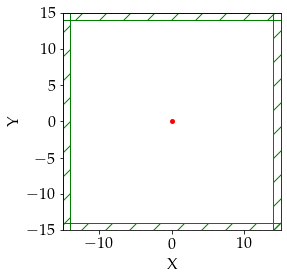

In [27]:
sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(0,0,0),size=mp.Vector3(length,length,0)))

In [28]:
pt = mp.Vector3(0,0)
sim.run(mp.dft_ldos( fcen, df, nfreq),until_after_sources=mp.stop_when_fields_decayed(25,mp.Ex,pt,1e-8))

on time step 70 (time=8.75), 0.057385 s/step
on time step 196 (time=24.5), 0.0317636 s/step
field decay(t = 25.125): 1.6946264371122945 / 1.6946264371122945 = 1.0
on time step 315 (time=39.375), 0.0336226 s/step
field decay(t = 50.25): 1.0303012227958261e-07 / 1.6946264371122945 = 6.079813227459718e-08
on time step 444 (time=55.5), 0.0311198 s/step
on time step 576 (time=72), 0.0303307 s/step
field decay(t = 75.375): 2.375869267111256e-10 / 1.6946264371122945 = 1.4020017716469857e-10
ldos0:, 0.06749999999999995, 0.005123563975512052
ldos0:, 0.06912324649298592, 0.0061441150286318386
ldos0:, 0.0707464929859719, 0.007222402504519529
ldos0:, 0.07236973947895786, 0.007990259631161761
ldos0:, 0.07399298597194384, 0.008274591022187755
ldos0:, 0.07561623246492981, 0.00815111746313298
ldos0:, 0.07723947895791579, 0.007877221793041343
ldos0:, 0.07886272545090176, 0.007750225983561171
ldos0:, 0.08048597194388774, 0.007965388443569978
ldos0:, 0.0821092184368737, 0.008538624876958294
ldos0:, 0.083

In [29]:
gix0=sim.ldos_data
print(np.shape(gix0))

(500,)


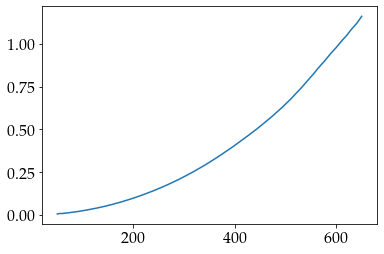

In [30]:
plt.plot(np.linspace(50,650,500),np.real(gix0))

In [31]:
N = 27

cell = mp.Vector3(length, length, lengthz)                      # 3D case

dpml = 1

pml_layers = [mp.PML(dpml)]

geometry = [mp.Block(center=mp.Vector3(0,0,0), 
            size=mp.Vector3(length-2*dpml,length-2*dpml,t), 
            material=mp.Medium(index = 2))]                    # Block of SiN extending up to PML region 

# A hexagonal prism defined by six vertices centered on the origin
# of material crystalline silicon (from the materials library)

multiplier = (1-t)*0.5

multiplier*1/np.sqrt(3)

vertices = [mp.Vector3(0,multiplier*2/np.sqrt(3)),
            mp.Vector3(multiplier*1,multiplier*1/np.sqrt(3)),
            mp.Vector3(multiplier*1,-multiplier*1/np.sqrt(3)),
            mp.Vector3(0,multiplier*-2/np.sqrt(3)),
            mp.Vector3(-multiplier*1,-multiplier*1/np.sqrt(3)),
            mp.Vector3(-multiplier*1,multiplier*1/np.sqrt(3))]

from hexalattice.hexalattice import *
hex_centers, _ = create_hex_grid(nx=N, ny=N, crop_circ=N//2)

for center in hex_centers: 
    center_final = mp.Vector3(center[0], center[1])
    geometry.append(mp.Prism(vertices,
                                     height=t,
                                     center=center_final,
                                     material=mp.Medium(index = 1))) #add the hexagons in the lattice
#for i in range(-N+1,N):
#    for j in range(-N+1,N):
#            geometry.append(mp.Prism(vertices,
#                                     height=t,
#                                     center=mp.Vector3(i*0.5-j*0.5, i*np.sqrt(3) / 2 + j*np.sqrt(3) / 2),
#                                     material=mp.Medium(index = 1))) #add the hexagons in the lattice

                 
src = [mp.Source(src=mp.GaussianSource(fcen, fwidth=1),
                     center=mp.Vector3(x=0, y=0, z=0),
                     component=mp.Ex, 
                     amplitude=1.0),
      ]


sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=src,
                    resolution=resolution,
                    force_complex_fields=True
                   )

nfreq = 500

nonpml_vol = mp.Volume(mp.Vector3(), size=mp.Vector3(2/resolution,2/resolution,2/resolution))

-----------
Initializing structure...
time for choose_chunkdivision = 0.00080204 s
Working in 3D dimensions.
Computational cell is 30 x 30 x 5 with resolution 4
     block, center = (0,0,0)
          size (28,28,0.444444)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4,4,4)
     prism, center = (-6.5,-11.2583,0)
          height 0.444444, axis (0,0,1), sidewall angle: 0 radians, 6 vertices:
          (-6.5,-10.9376,-0.222222)
          (-6.22222,-11.098,-0.222222)
          (-6.22222,-11.4187,-0.222222)
          (-6.5,-11.5791,-0.222222)
          (-6.77778,-11.4187,-0.222222)
          (-6.77778,-11.098,-0.222222)
          dielectric constant epsilon diagonal = (1,1,1)
     prism, center = (-5.5,-11.2583,0)
          height 0.444444, axis (0,0,1), sidewall angle: 0 radians, 6 vertices:
          (-5.5,-10.9376,-0.222222)
          (-5.22222,-11.098,-0.222222)
          (-5.22222,-11.4187,-0.222222)
          (-5.5,-11.5791,-0.222222)
    

<AxesSubplot:xlabel='X', ylabel='Y'>

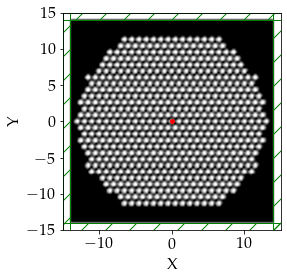

In [32]:
sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(0,0,0),size=mp.Vector3(length,length,0)))

In [33]:
sim.run(mp.dft_ldos( fcen, df, nfreq),until=200)

Meep progress: 8.875/200.0 = 4.4% done in 4.0s, 86.6s to go
on time step 71 (time=8.875), 0.0566646 s/step
Meep progress: 25.125/200.0 = 12.6% done in 8.0s, 55.9s to go
on time step 201 (time=25.125), 0.0307776 s/step
Meep progress: 40.5/200.0 = 20.2% done in 12.0s, 47.4s to go
on time step 324 (time=40.5), 0.0327027 s/step
Meep progress: 56.5/200.0 = 28.2% done in 16.1s, 40.8s to go
on time step 452 (time=56.5), 0.0314775 s/step
Meep progress: 72.0/200.0 = 36.0% done in 20.1s, 35.7s to go
on time step 576 (time=72), 0.0324038 s/step
Meep progress: 87.25/200.0 = 43.6% done in 24.1s, 31.2s to go
on time step 698 (time=87.25), 0.0329345 s/step
Meep progress: 104.125/200.0 = 52.1% done in 28.1s, 25.9s to go
on time step 833 (time=104.125), 0.029729 s/step
Meep progress: 120.625/200.0 = 60.3% done in 32.1s, 21.1s to go
on time step 965 (time=120.625), 0.0303268 s/step
Meep progress: 137.125/200.0 = 68.6% done in 36.2s, 16.6s to go
on time step 1097 (time=137.125), 0.0305021 s/step
Meep pro

In [34]:
gix=sim.ldos_data
print(np.shape(gix))

(500,)


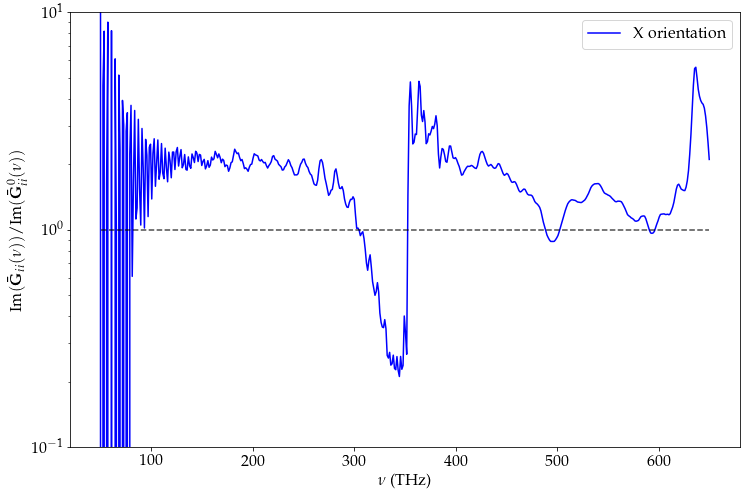

In [35]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(np.linspace(50,650,500),np.real(gix)/np.real(gix0), label='X orientation', color='blue')
ax.plot(np.linspace(50,650,500),np.ones(500), linestyle='dashed', color='black', alpha=0.7)
ax.set_yscale('log')
ax.set_ylim([0.1,10])
ax.set_ylabel('Im$(\mathbf{\\bar{G}}_{ii}(\\nu))$/Im$(\mathbf{\\bar{G}}^{0}_{ii}(\\nu))$')
ax.set_xlabel('$\\nu$ (THz)')
ax.legend()

In [16]:
cell = mp.Vector3(length, length, lengthz)                      # 3D case

dpml = 1

pml_layers = [mp.PML(dpml)]

geometry = [mp.Block(center=mp.Vector3(0,0,0), 
            size=mp.Vector3(length-2*dpml,length-2*dpml,t), 
            material=mp.Medium(index = 1))]                    # Block of air extending up to PML region 

                 
src = [mp.Source(src=mp.GaussianSource(fcen, fwidth=0.5),
                     center=mp.Vector3(x=0, y=0, z=0),
                     component=mp.Ey, 
                     amplitude=1.0),
      ]


sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=src,
                    resolution=resolution,
                    force_complex_fields=True
                   )

nfreq = 500

nonpml_vol = mp.Volume(mp.Vector3(), size=mp.Vector3(2/resolution,2/resolution,2/resolution))

In [17]:
sim.run(mp.dft_ldos( fcen, df, nfreq),until_after_sources=mp.stop_when_fields_decayed(25,mp.Ey,pt,1e-8))

-----------
Initializing structure...
time for choose_chunkdivision = 0.000602007 s
Working in 3D dimensions.
Computational cell is 30 x 30 x 5 with resolution 12
     block, center = (0,0,0)
          size (28,28,0.444444)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 16.2761 s
-----------
Meep: using complex fields.
on time step 1 (time=0.0416667), 17.063 s/step
on time step 9 (time=0.375), 0.556227 s/step
on time step 17 (time=0.708333), 0.550529 s/step
on time step 25 (time=1.04167), 0.549913 s/step
on time step 33 (time=1.375), 0.554995 s/step
on time step 41 (time=1.70833), 0.549499 s/step
on time step 49 (time=2.04167), 0.552686 s/step
on time step 57 (time=2.375), 0.553372 s/step
on time step 65 (time=2.70833), 0.553126 s/step
on time step 73 (time=3.04167), 0.549286 s/step
on time step 81 (time=3.375), 0.550389 s/step
on time step 89 (time=3.70833), 0.553044 s/step
on time step 97 (time=4.04167), 0.5502

In [18]:
giy0=sim.ldos_data

In [19]:
cell = mp.Vector3(length, length, lengthz)                      # 3D case

dpml = 1

pml_layers = [mp.PML(dpml)]

geometry = [mp.Block(center=mp.Vector3(0,0,0), 
            size=mp.Vector3(length-2*dpml,length-2*dpml,t), 
            material=mp.Medium(index = 2))]                    # Block of SiN extending up to PML region 

# A hexagonal prism defined by six vertices centered on the origin
# of material crystalline silicon (from the materials library)

multiplier = (1-t)*0.5

multiplier*1/np.sqrt(3)

vertices = [mp.Vector3(0,multiplier*2/np.sqrt(3)),
            mp.Vector3(multiplier*1,multiplier*1/np.sqrt(3)),
            mp.Vector3(multiplier*1,-multiplier*1/np.sqrt(3)),
            mp.Vector3(0,multiplier*-2/np.sqrt(3)),
            mp.Vector3(-multiplier*1,-multiplier*1/np.sqrt(3)),
            mp.Vector3(-multiplier*1,multiplier*1/np.sqrt(3))]

from hexalattice.hexalattice import *
hex_centers, _ = create_hex_grid(nx=N, ny=N, crop_circ=N//2)

for center in hex_centers: 
    center_final = mp.Vector3(center[0], center[1])
    geometry.append(mp.Prism(vertices,
                                     height=t,
                                     center=center_final,
                                     material=mp.Medium(index = 1))) #add the hexagons in the lattice
#for i in range(-N+1,N):
#    for j in range(-N+1,N):
#            geometry.append(mp.Prism(vertices,
#                                     height=t,
#                                     center=mp.Vector3(i*0.5-j*0.5, i*np.sqrt(3) / 2 + j*np.sqrt(3) / 2),
#                                     material=mp.Medium(index = 1))) #add the hexagons in the lattice

                 
src = [mp.Source(src=mp.GaussianSource(fcen, fwidth=0.5),
                     center=mp.Vector3(x=0, y=0, z=0),
                     component=mp.Ey, 
                     amplitude=1.0),
      ]


sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=src,
                    resolution=resolution,
                    force_complex_fields=True
                   )

nfreq = 500

In [20]:
sim.run(mp.dft_ldos( fcen, df, nfreq),until=750)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00134897 s
Working in 3D dimensions.
Computational cell is 30 x 30 x 5 with resolution 12
     block, center = (0,0,0)
          size (28,28,0.444444)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4,4,4)
     prism, center = (-6.5,-11.2583,0)
          height 0.444444, axis (0,0,1), sidewall angle: 0 radians, 6 vertices:
          (-6.5,-10.9376,-0.222222)
          (-6.22222,-11.098,-0.222222)
          (-6.22222,-11.4187,-0.222222)
          (-6.5,-11.5791,-0.222222)
          (-6.77778,-11.4187,-0.222222)
          (-6.77778,-11.098,-0.222222)
          dielectric constant epsilon diagonal = (1,1,1)
     prism, center = (-5.5,-11.2583,0)
          height 0.444444, axis (0,0,1), sidewall angle: 0 radians, 6 vertices:
          (-5.5,-10.9376,-0.222222)
          (-5.22222,-11.098,-0.222222)
          (-5.22222,-11.4187,-0.222222)
          (-5.5,-11.5791,-0.222222)
   

In [21]:
giy=sim.ldos_data
ax.plot(np.linspace(300,400,500),np.real(giy)/np.real(giy0), label='Y orientation', color='red')
ax.legend()

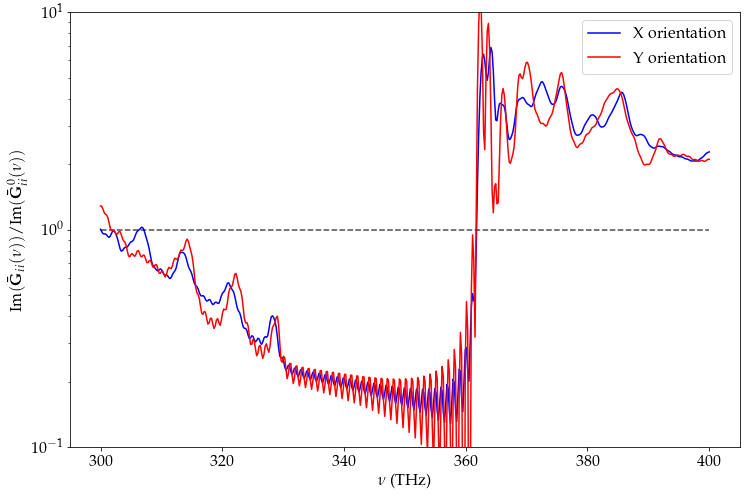

In [22]:
fig

In [23]:
cell = mp.Vector3(length, length, lengthz)                      # 3D case

dpml = 1

pml_layers = [mp.PML(dpml)]

geometry = [mp.Block(center=mp.Vector3(0,0,0), 
            size=mp.Vector3(length-2*dpml,length-2*dpml,t), 
            material=mp.Medium(index = 1))]                    # Block of air extending up to PML region 

                 
src = [mp.Source(src=mp.GaussianSource(fcen, fwidth=0.5),
                     center=mp.Vector3(x=0, y=0, z=0),
                     component=mp.Ez, 
                     amplitude=1.0),
      ]


sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=src,
                    resolution=resolution,
                    force_complex_fields=True
                   )

nfreq = 500

In [24]:
sim.run(mp.dft_ldos( fcen, df, nfreq),until_after_sources=mp.stop_when_fields_decayed(25,mp.Ez,pt,1e-8))

-----------
Initializing structure...
time for choose_chunkdivision = 0.000593901 s
Working in 3D dimensions.
Computational cell is 30 x 30 x 5 with resolution 12
     block, center = (0,0,0)
          size (28,28,0.444444)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 16.6104 s
-----------
Meep: using complex fields.
on time step 1 (time=0.0416667), 16.9691 s/step
on time step 9 (time=0.375), 0.55273 s/step
on time step 17 (time=0.708333), 0.551041 s/step
on time step 25 (time=1.04167), 0.550759 s/step
on time step 33 (time=1.375), 0.550146 s/step
on time step 41 (time=1.70833), 0.553362 s/step
on time step 49 (time=2.04167), 0.552866 s/step
on time step 57 (time=2.375), 0.551356 s/step
on time step 65 (time=2.70833), 0.550585 s/step
on time step 73 (time=3.04167), 0.551578 s/step
on time step 81 (time=3.375), 0.558259 s/step
on time step 89 (time=3.70833), 0.553149 s/step
on time step 97 (time=4.04167), 0.5519

In [25]:
giz0=sim.ldos_data

In [26]:
cell = mp.Vector3(length, length, lengthz)                      # 3D case

dpml = 1

pml_layers = [mp.PML(dpml)]

geometry = [mp.Block(center=mp.Vector3(0,0,0), 
            size=mp.Vector3(length-2*dpml,length-2*dpml,t), 
            material=mp.Medium(index = 2))]                    # Block of SiN extending up to PML region 

# A hexagonal prism defined by six vertices centered on the origin
# of material crystalline silicon (from the materials library)

multiplier = (1-t)*0.5

multiplier*1/np.sqrt(3)

vertices = [mp.Vector3(0,multiplier*2/np.sqrt(3)),
            mp.Vector3(multiplier*1,multiplier*1/np.sqrt(3)),
            mp.Vector3(multiplier*1,-multiplier*1/np.sqrt(3)),
            mp.Vector3(0,multiplier*-2/np.sqrt(3)),
            mp.Vector3(-multiplier*1,-multiplier*1/np.sqrt(3)),
            mp.Vector3(-multiplier*1,multiplier*1/np.sqrt(3))]

from hexalattice.hexalattice import *
hex_centers, _ = create_hex_grid(nx=N, ny=N, crop_circ=N//2)

for center in hex_centers: 
    center_final = mp.Vector3(center[0], center[1])
    geometry.append(mp.Prism(vertices,
                                     height=t,
                                     center=center_final,
                                     material=mp.Medium(index = 1))) #add the hexagons in the lattice
#for i in range(-N+1,N):
#    for j in range(-N+1,N):
#            geometry.append(mp.Prism(vertices,
#                                     height=t,
#                                     center=mp.Vector3(i*0.5-j*0.5, i*np.sqrt(3) / 2 + j*np.sqrt(3) / 2),
#                                     material=mp.Medium(index = 1))) #add the hexagons in the lattice

                 
src = [mp.Source(src=mp.GaussianSource(fcen, fwidth=0.5),
                     center=mp.Vector3(x=0, y=0, z=0),
                     component=mp.Ez, 
                     amplitude=1.0),
      ]


sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=src,
                    resolution=resolution,
                    force_complex_fields=True
                   )

nfreq = 500

In [27]:
sim.run(mp.dft_ldos( fcen, df, nfreq),until=750)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00103617 s
Working in 3D dimensions.
Computational cell is 30 x 30 x 5 with resolution 12
     block, center = (0,0,0)
          size (28,28,0.444444)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4,4,4)
     prism, center = (-6.5,-11.2583,0)
          height 0.444444, axis (0,0,1), sidewall angle: 0 radians, 6 vertices:
          (-6.5,-10.9376,-0.222222)
          (-6.22222,-11.098,-0.222222)
          (-6.22222,-11.4187,-0.222222)
          (-6.5,-11.5791,-0.222222)
          (-6.77778,-11.4187,-0.222222)
          (-6.77778,-11.098,-0.222222)
          dielectric constant epsilon diagonal = (1,1,1)
     prism, center = (-5.5,-11.2583,0)
          height 0.444444, axis (0,0,1), sidewall angle: 0 radians, 6 vertices:
          (-5.5,-10.9376,-0.222222)
          (-5.22222,-11.098,-0.222222)
          (-5.22222,-11.4187,-0.222222)
          (-5.5,-11.5791,-0.222222)
   

In [28]:
giz=sim.ldos_data
ax.plot(np.linspace(300,400,500),np.real(giz)/np.real(giz0), label='Z orientation', color='green')
ax.legend()

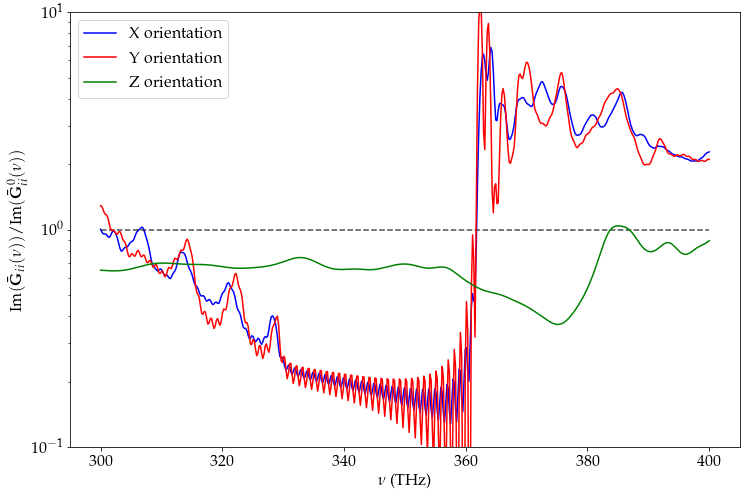

In [29]:
fig

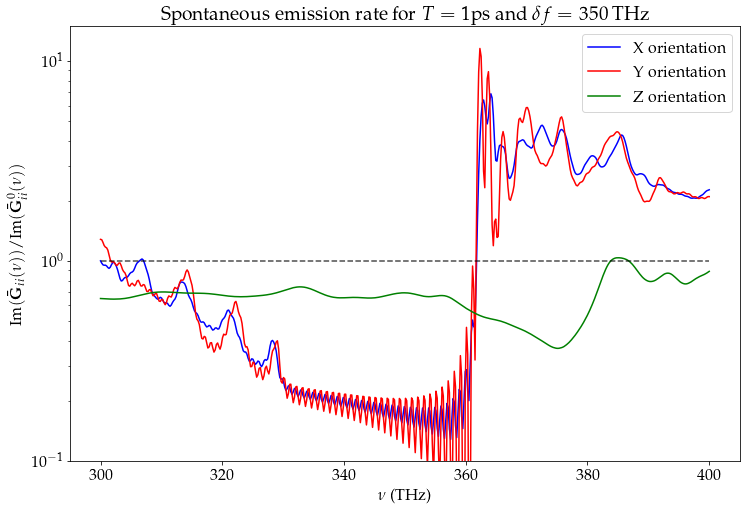

In [38]:
fig2, ax2 = plt.subplots(figsize=(12,8))


ax2.plot(np.linspace(300,400,500),np.real(gix)/np.real(gix0), label='X orientation', color='blue')
ax2.plot(np.linspace(300,400,500),np.real(giy)/np.real(giy0), label='Y orientation', color='red')
ax2.plot(np.linspace(300,400,500),np.real(giz)/np.real(giz0), label='Z orientation', color='green')

ax2.plot(np.linspace(300,400,500),np.ones(500), linestyle='dashed', color='black', alpha=0.7)

ax2.set_yscale('log')
ax2.set_ylim([0.1,15])
ax2.set_ylabel('Im$(\mathbf{\\bar{G}}_{ii}(\\nu))$/Im$(\mathbf{\\bar{G}}^{0}_{ii}(\\nu))$')
ax2.set_xlabel('$\\nu$ (THz)')
ax2.set_title('Spontaneous emission rate for $T=1$ps and $\delta f=350$ THz')
ax2.legend()


In [39]:
fig2.savefig('imag_green_func_title.pdf')

In [33]:
print('Simulation time', 750*a/c* 10**12,'ps')

Simulation time 1.0125 ps
